<div align="center">
<h1>Desafio Data Analitycs</h1>
<img src="https://assets.bizneo.com/system/images/files/014/613/598/original/Frexco_Transp.png?1617635198" width="30%"></img>
<p>Resolvido por: <b>Micael Muniz</b><br>
Data e hora de conclusão: 31/01/23 23:45</p>
</div>

<h2>Parte 1: Analisando os Dados</h2>

In [292]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [293]:
dataset = pd.read_csv("dados.csv", delimiter=";")
dataset.head(5)

,Data,Vendas
0,6/12/2022,870
1,7/12/2022,868
2,8/12/2022,1189
3,9/12/2022,742
4,10/12/2022,317


In [294]:
print(type(dataset["Vendas"][2]))
print(dataset.columns)

<class 'numpy.int64'>
Index(['Data', 'Vendas'], dtype='object')


*PS: o dataset, originalmente em xlsx, formato do Excel, foi salvo como arquivo CSV, para maior flexibilidade e praticidade*


In [295]:
# converter a coluna de data de string para o tipo Timestamp
dataset['Data'] = pd.to_datetime(dataset['Data'], format="%d/%m/%Y")
print(type(dataset['Data'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [296]:
dataset.head(5)

,Data,Vendas
0,2022-12-06,870
1,2022-12-07,868
2,2022-12-08,1189
3,2022-12-09,742
4,2022-12-10,317


<h4>Funções utilitárias<h4>

In [297]:
def show_plot(dataset_plot, timestamp = None):
  """
  Exibe um gráfico de linha com o dataset fornecido, contendo uma linha no timestamp
  """
  # Definindo a data como o index para melhor visualização do gráfico
  dataset_view = dataset_plot[['Data', 'Vendas']].copy()
  dataset_view.set_index('Data', inplace=True)

  ax = dataset_view.plot(kind='line')

  if timestamp:
    # Adicionar a linha vertical usando o índice timestamp
    vertical_line_timestamp = timestamp
    ax.axvline(x=vertical_line_timestamp, color='red', linestyle='--', linewidth=2, alpha=0.5)

    # Adicionar a anotação "predição" na parte inferior à direita da linha
    x_pos = vertical_line_timestamp
    y_pos = ax.get_ylim()[0]
    ax.annotate("predição", (x_pos, y_pos), xytext=(1, 0.8), textcoords='axes fraction',
                fontsize=14, ha='center', va='bottom')
  plt.tight_layout()
  plt.show()

def update_dataframe(df, sales):
  """
  Atualiza o dataframe com 5 novas linhas contendo a previsão gerada por algum modelo
  """
  new_sales = []
  for i in range(1, 6):
      new_date = df['Data'].iloc[-1] + timedelta(days=i)
      new_line = {'Data': new_date, 
                    'Vendas': sales[i-1], 
                    'dia_semana': (new_date.weekday() + 1) % 7, 
                    'semana_ano': new_date.strftime('%U'), 
                    'dia_mes': new_date.day}
      new_sales.append(new_line)
  return df.append(new_sales, ignore_index=True)

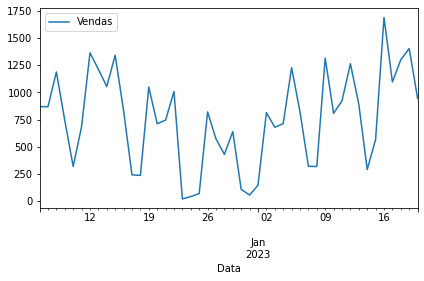

In [298]:
show_plot(dataset)

*gráfico dos dados originais, mostra como o crescimento e declinio das vendas, percebe-se um padrão*

<h2>Parte 2 - Tratando os dados... Um pouco mais</h2>

*Normalmente trabalho com inteiros, floats e strings ao treinar modelos de ML, mas nunca usei datas como um tipo próprio e uma informação relevante para o modelo no formato DDMMYYYY, por essa razão, optei por <i>"descartar"</i> a coluna data e criar novas colunas com informações derivadas da data, como dia da semana, semana do ano e dia do mês. Além disso, defini a coluna "data" como o índice.*

In [299]:
# criando novas colunas derivadas do 'data' 
dataset['dia_semana'] = dataset['Data'].dt.weekday
dataset['semana_ano'] = dataset['Data'].dt.weekofyear
dataset['dia_mes'] = dataset['Data'].dt.day
last_day = dataset['Data'].iloc[-1]
#dataset.set_index('Data', inplace=True)

dataset.head(10)

<ipython-input-299-a28cb3b740d7>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dataset['semana_ano'] = dataset['Data'].dt.weekofyear


,Data,Vendas,dia_semana,semana_ano,dia_mes
0,2022-12-06,870,1,49,6
1,2022-12-07,868,2,49,7
2,2022-12-08,1189,3,49,8
3,2022-12-09,742,4,49,9
4,2022-12-10,317,5,49,10
5,2022-12-11,685,6,49,11
6,2022-12-12,1366,0,50,12
7,2022-12-13,1213,1,50,13
8,2022-12-14,1055,2,50,14
9,2022-12-15,1343,3,50,15


<h2>Parte 3: testando modelos de Machine Learning</h2>

#### Modelos possiveis de se utilizar para tarefa de previsão de vendas

- [x] [Regressão Linear](https://medium.com/@lauradamaceno/regressão-linear-6a7f247c3e29) é um algoritmo supervisionado de machine learning usado para estimar o valor de algo baseado em uma série de outros dados históricos, portanto olhando para o passado você pode “prever” o futuro.
- [x] [Random Forest](https://icmcjunior.com.br/random-forest/#:~:text=O%20que%20é%20Random%20Forest,para%20chegar%20no%20resultado%20final.) Resumidamente, o algoritmo cria de forma aleatória várias Árvores de Decisão (Decision Trees) e combina o resultado de todas elas para chegar no resultado final.
- [x] [LSTM (Long Short-Term Memory)](https://medium.com/@web2ajax/redes-neurais-recorrentes-lstm-b90b720dc3f6) são um tipo especial de RNN, capaz de aprender dependências de longo prazo.
- [ ] [SARIMA (Seasonal Autoregressive Integrated Moving Average) ](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

#### Regressão linear


In [319]:
# Copiando o dataset
reg_lin = dataset.copy()

# Definindo o target (vendas) e as features (dia da semana, semana do ano, dia do mês)
target = reg_lin["Vendas"]
features = reg_lin[["dia_semana", "semana_ano", "dia_mes"]]

# Separando os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=1)

# Carregando o modelo de regressão linear
reg = LinearRegression()

# Treinando o modelo com os dados de treinamento
reg.fit(X_train.values, y_train.values)
y_pred = reg.predict(X_test.values)

# calcula o erro absoluto
mae_lin = mean_absolute_error(y_test, y_pred)

print(f"Acurácia: em média, as previsões do modelo erram por {int(mae_lin)} unidades de vendas.")

Acurácia: em média, as previsões do modelo erram por 250 unidades de vendas.


In [320]:
next_5_days = np.array([[i % 7, (i // 7) + last_day.weekofyear, i + last_day.day] for i in range(5)])
next_5_days_pred = reg.predict(next_5_days)
print("Previsão das vendas nos proximos 5 dias: ", end='')
for day in next_5_days_pred:
  print(int(day), end=', ')

Previsão das vendas nos proximos 5 dias: 1303, 1149, 994, 840, 686, 

In [321]:
reg_lin = update_dataframe(reg_lin, next_5_days_pred.astype(int))
reg_lin.tail(7)

,Data,Vendas,dia_semana,semana_ano,dia_mes
44,2023-01-19,1405,3,3,19
45,2023-01-20,945,4,3,20
46,2023-01-21,1303,6,03,21
47,2023-01-22,1149,0,04,22
48,2023-01-23,994,1,04,23
49,2023-01-24,840,2,04,24
50,2023-01-25,686,3,04,25


*PS: da linha 46 até a 50 é a previsão de vendas, o dataset original só possui 45 linhas*

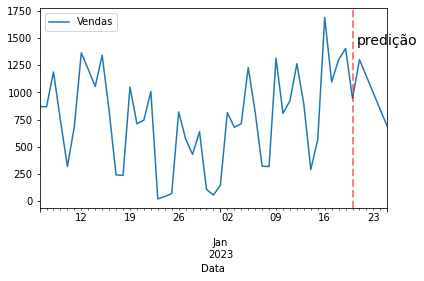

In [322]:
show_plot(reg_lin, timestamp=reg_lin['Data'].iloc[-6])

#### Random Forest


In [323]:
# Copiando o dataset
reg_rf = dataset.copy()

# Definindo o target (vendas) e as features (dia da semana, semana do ano, dia do mês)
target = reg_rf["Vendas"]
features = reg_rf[["dia_semana", "semana_ano", "dia_mes"]]

# Separando os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=6)

# Carregando o modelo de random forest
reg = RandomForestRegressor(n_estimators=100, random_state=6)

# Treinando o modelo com os dados de treinamento
reg.fit(X_train.values, y_train.values)
y_pred = reg.predict(X_test.values)

# calcula o erro absoluto
mae_rf = mean_absolute_error(y_test, y_pred)
print(f"Acurácia: em média, as previsões do modelo erram por {int(mae_rf)} unidades de vendas.")

Acurácia: em média, as previsões do modelo erram por 128 unidades de vendas.


In [324]:
next_5_days = np.array([[i % 7, (i // 7) + last_day.weekofyear, i + last_day.day] for i in range(5)])
next_5_days_pred = reg.predict(next_5_days)
print("Previsão das vendas nos proximos 5 dias: ", end='')
for day in next_5_days_pred:
  print(int(day), end=', ')

Previsão das vendas nos proximos 5 dias: 1217, 1000, 1007, 1089, 587, 

In [325]:
reg_rf = update_dataframe(reg_rf, next_5_days_pred.astype(int))
reg_rf.tail(7)

,Data,Vendas,dia_semana,semana_ano,dia_mes
44,2023-01-19,1405,3,3,19
45,2023-01-20,945,4,3,20
46,2023-01-21,1217,6,03,21
47,2023-01-22,1000,0,04,22
48,2023-01-23,1007,1,04,23
49,2023-01-24,1089,2,04,24
50,2023-01-25,587,3,04,25


*PS: da linha 46 até a 50 é a previsão de vendas, o dataset original só possui 45 linhas*

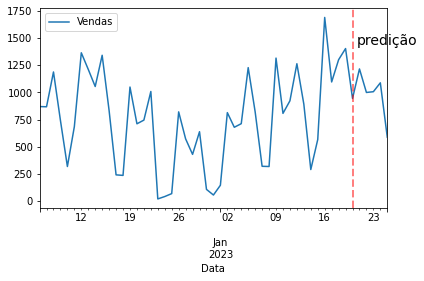

In [326]:
show_plot(reg_rf, timestamp=reg_rf['Data'].iloc[-6])

#### LSTM (Long Short-Term Memory)


In [345]:
# Copiando o dataset
lstm = dataset[['Data', 'Vendas']].copy()
#lstm.set_index('Data', inplace=True)

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
lstm['Vendas'] = scaler.fit_transform(lstm['Vendas'].values.reshape(-1, 1))

# split data
train, test = train_test_split(lstm, train_size=0.85, shuffle=False)

# create dataset
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

# Look back setado em 5 por ser +- o ciclo das vendas em dias
look_back = 5
trainX, trainY = create_dataset(train['Vendas'].values.reshape(-1, 1), look_back)
testX, testY = create_dataset(test['Vendas'].values.reshape(-1, 1), look_back)

# como LSTM é um modelo temporal, é necessario lidar com o tempo, ou seja, isso 
# adiciona uma nova dimensão a nossa matriz (2d) transformando ela em um tensor (3d)  
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1)) # ReLU
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# predições (train e teste pra avaliar se está havendo overlifiting)
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# inverte predições
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/100
33/33 - 2s - loss: 0.1969 - 2s/epoch - 69ms/step
Epoch 2/100
33/33 - 0s - loss: 0.1601 - 56ms/epoch - 2ms/step
Epoch 3/100
33/33 - 0s - loss: 0.1292 - 87ms/epoch - 3ms/step
Epoch 4/100
33/33 - 0s - loss: 0.1043 - 56ms/epoch - 2ms/step
Epoch 5/100
33/33 - 0s - loss: 0.0861 - 55ms/epoch - 2ms/step
Epoch 6/100
33/33 - 0s - loss: 0.0726 - 59ms/epoch - 2ms/step
Epoch 7/100
33/33 - 0s - loss: 0.0661 - 58ms/epoch - 2ms/step
Epoch 8/100
33/33 - 0s - loss: 0.0627 - 62ms/epoch - 2ms/step
Epoch 9/100
33/33 - 0s - loss: 0.0608 - 54ms/epoch - 2ms/step
Epoch 10/100
33/33 - 0s - loss: 0.0604 - 62ms/epoch - 2ms/step
Epoch 11/100
33/33 - 0s - loss: 0.0593 - 62ms/epoch - 2ms/step
Epoch 12/100
33/33 - 0s - loss: 0.0592 - 59ms/epoch - 2ms/step
Epoch 13/100
33/33 - 0s - loss: 0.0592 - 57ms/epoch - 2ms/step
Epoch 14/100
33/33 - 0s - loss: 0.0590 - 61ms/epoch - 2ms/step
Epoch 15/100
33/33 - 0s - loss: 0.0587 - 57ms/epoch - 2ms/step
Epoch 16/100
33/33 - 0s - loss: 0.0584 - 57ms/epoch - 2ms/step
Ep

In [346]:
# calculate root mean squared error
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))
print(f"Acurácia: em média, as previsões do modelo erram por {int(testScore)} unidades de vendas.")

Train Score: 311.09 MAE
Test Score: 371.44 MAE
Acurácia: em média, as previsões do modelo erram por 371 unidades de vendas.


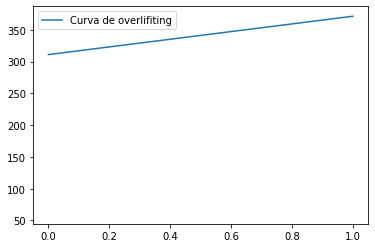

In [347]:
dif = testScore - trainScore

plt.plot([0, 1], [trainScore, testScore], label='Curva de overlifiting')
plt.plot([0, 1], [dif, dif],alpha=0)
plt.legend()
plt.show()

In [348]:
# Prever os próximos 5 dias

def prever_proximos_5_dias(model, scaler, lstm, ultimos_5_dias):
    next_day_pred = model.predict(np.reshape(ultimos_5_dias, (1, 1, 5)))
    next_day_pred = scaler.inverse_transform(next_day_pred)
    return int(next_day_pred[0][0])

ultimos_5_dias = lstm.tail(5)
ultimos_5_dias = np.array(ultimos_5_dias['Vendas'].values)

next_5_days_pred = []
for i in range(5):
    next_day = prever_proximos_5_dias(model, scaler, lstm, ultimos_5_dias)
    next_5_days_pred.append(next_day)
    ultimos_5_dias = np.append(ultimos_5_dias[1:], next_day)

next_5_days_pred = np.array(next_5_days_pred)

print("Previsão das vendas nos próximos 5 dias: ", end='')
for day in next_5_days_pred:
    print(day, end=', ')

1/1 [==============================] - 0s 16ms/step
Previsão das vendas nos próximos 5 dias: 710, 1339, 1659, 1659, 1339, 

In [349]:
new_lstm = dataset.copy()
new_lstm = update_dataframe(new_lstm, next_5_days_pred)
new_lstm.tail(7)

,Data,Vendas,dia_semana,semana_ano,dia_mes
44,2023-01-19,1405,3,3,19
45,2023-01-20,945,4,3,20
46,2023-01-21,710,6,03,21
47,2023-01-22,1339,0,04,22
48,2023-01-23,1659,1,04,23
49,2023-01-24,1659,2,04,24
50,2023-01-25,1339,3,04,25


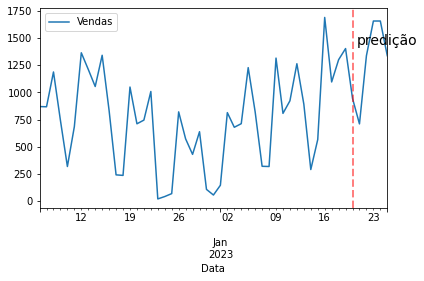

In [350]:
show_plot(new_lstm, timestamp=new_lstm['Data'].iloc[-6])

# Parte 4: Resultados obtidos

## Comparação entre os modelos
|  Nome do modelo | MAE | Vantagens | Desvantagens |
|---|---|---|---|
| Regressão Linear | 250 |simples, funciona quando há uma relação linear entre entrada e saida.  | não funciona com interações não lineares ou efeitos sazonais complexos |
| Random Forest | 128 | lida com efeitos sazonais complexos e não lineares | suscetível ao overfitting |
| LSTM | 371 |é a técnica adequada para previsão sazonal de longo prazo | exige muitos dados para ser treinada, devido a sua natureza de memoriazação|
| SARIMA  |N/A| eficaz para prever séries temporais com sazonalidade e tendência  | complexo |

## Explicando os resultados

- Regressão Linear é uma técnica simples, mas não é adequada para datasets pequenos ou complexos. Neste caso, o dataset é padronizado, mas ainda é insuficiente para treinar a regressão linear. Isso se torna evidente quando ocorre uma alocação maior de dados para o teste em relação ao treino, resultando em uma diminuição da precisão. Ao contrário disso, com menos dados para teste e uma quantidade maior de dados de treinamento, a precisão tende a ser maior, mesmo para prever os dados "inéditos" de teste.
- Random Forest é capaz de lidar com datasets menores e mais complexos, encontrando padrões de forma mais eficiente, o que se aplica perfeitamente ao nosso caso.
- LSTM é uma técnica eficiente para previsão de séries temporais, amplamente utilizada para prever tendências de vendas. No entanto, devido à sua natureza de memorização, precisa de uma grande quantidade de dados para ser treinada adequadamente. Infelizmente, o nosso dataset possui apenas 45 linhas, o que torna a utilização do LSTM improvável para atingir uma alta acurácia.

## Conclusão e possiveis melhorias
A análise pode ser significativamente aperfeiçoada se o dataset tiver mais informações, como por exemplo, o histórico de vendas dos últimos dois anos. Neste caso, seria possível adicionar novas colunas, como se é feriado ou não, a época do ano, e até mesmo integrar com uma API para obter tendências no Twitter e notícias relevantes. Dessa forma, seria possível prever as vendas futuras de uma empresa com uma alta precisão.


<hr>



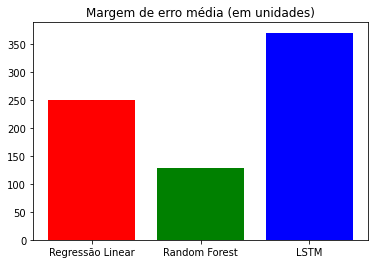

In [351]:
plt.bar(["Regressão Linear"], [250], color='red')
plt.bar(["Random Forest"], [128], color='green')
plt.bar(["LSTM"], [371], color='blue')
plt.title("Margem de erro média (em unidades)")
plt.show()

*Random Forest é o modelo vencedor devido à sua alta precisão de previsão, com uma média de 128 unidades de distância do resultado real.*

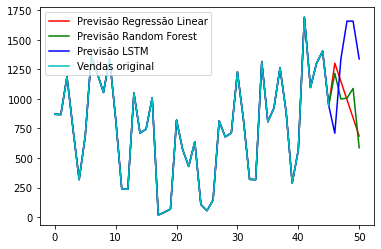

In [352]:
plt.plot(reg_lin['Vendas'], 'red', label='Previsão Regressão Linear')
plt.plot(reg_rf['Vendas'], 'green', label='Previsão Random Forest')
plt.plot(new_lstm['Vendas'], 'blue', label='Previsão LSTM')
plt.plot(dataset['Vendas'], 'c', label='Vendas original')
plt.legend()
plt.show()

*O gráfico apresenta a tendência prevista por cada modelo em comparação aos resultados de vendas reais, representados em azul*

In [354]:
reg_rf.tail(5)

,Data,Vendas,dia_semana,semana_ano,dia_mes
46,2023-01-21,1217,6,03,21
47,2023-01-22,1000,0,04,22
48,2023-01-23,1007,1,04,23
49,2023-01-24,1089,2,04,24
50,2023-01-25,587,3,04,25


*A previsão de vendas de 21 a 25 de janeiro de 2023 feita pelo modelo Random Forest (margem de erro de 128 unidades).*